In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns  # For visualizing the confusion matrix

# LOAD DATA

In [13]:
! git clone https://github.com/LiamHogarth123/Ai_Fungi_Finder.git

Cloning into 'Ai_Fungi_Finder'...
remote: Enumerating objects: 10065, done.
remote: Total 10065 (delta 0), reused 0 (delta 0), pack-reused 10065
Receiving objects: 100% (10065/10065), 2.46 GiB | 12.26 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Checking out files: 100% (10061/10061), done.


# Connect to drive

In [14]:
from google.colab import drive
drive.mount('/content/drive')


ModuleNotFoundError: No module named 'google.colab'

# Test Gpu

In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Number of GPUs available: {len(gpus)}")
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {gpu}")
else:
    print("No GPUs available")

Number of GPUs available: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Remove Corrupted Images

In [2]:
import os
from PIL import Image

def identify_corrupted_images(directory):
    corrupted_images = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    img.load()
            except OSError as e:
                print(f"Corrupted image: {img_path}")
                corrupted_images.append(img_path)
    return corrupted_images

# Replace '/path/to/dataset' with the path to your dataset directory
corrupted_images = identify_corrupted_images('/home/liam/git/Ai_Fungi_Finder/Data_V3/Training')

# Remove or replace corrupted images
for img_path in corrupted_images:
    # Remove the corrupted image
    os.remove(img_path)
    # Or replace with a placeholder image
    # placeholder_img.save(img_path)


# Load Plotting Function

In [9]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    num_epochs = len(model_history.history[acc])
    tick_positions = np.arange(1, num_epochs + 1, max(1, num_epochs // 10))

    axs[0].plot(range(1, num_epochs + 1), model_history.history[acc])
    axs[0].plot(range(1, num_epochs + 1), model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(tick_positions)
    axs[0].legend(['train', 'val'], loc='best')

    axs[1].plot(range(1, num_epochs + 1), model_history.history['loss'])
    axs[1].plot(range(1, num_epochs + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(tick_positions)
    axs[1].legend(['train', 'val'], loc='best')

    plt.show()

# Loading an equal amount of each mushroom species data set

In [37]:
import os
import shutil
from glob import glob

def copy_and_limit_images(source_dir, target_dir, max_images=80):
    # Ensure the target directory exists
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    categories = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for category in categories:
        # Make sure each category directory exists in the target directory
        category_target_dir = os.path.join(target_dir, category)
        if not os.path.exists(category_target_dir):
            os.makedirs(category_target_dir)

        # Get all images in the source directory for this category
        category_source_dir = os.path.join(source_dir, category)
        images = glob(os.path.join(category_source_dir, '*'))

        # Copy the first 'max_images' images to the target directory
        for image_path in images[:max_images]:
            shutil.copy(image_path, category_target_dir)

def copy_and_limit_images2(source_dir, target_dir, max_images=240):
    # Ensure the target directory exists
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    categories = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for category in categories:
        # Make sure each category directory exists in the target directory
        category_target_dir = os.path.join(target_dir, category)
        if not os.path.exists(category_target_dir):
            os.makedirs(category_target_dir)

        # Get all images in the source directory for this category
        category_source_dir = os.path.join(source_dir, category)
        images = glob(os.path.join(category_source_dir, '*'))

        # Copy the first 'max_images' images to the target directory
        for image_path in images[:max_images]:
            shutil.copy(image_path, category_target_dir)


# Define your source and target directories
source_train_dir = '/home/liam/git/Ai_Fungi_Finder/Data_V3/Training'
target_train_dir = '/home/liam/git/Ai_Fungi_Finder/Data_V3/Training_Limited'
source_test_dir = '/home/liam/git/Ai_Fungi_Finder/Data_V3/Testing'
target_test_dir = '/home/liam/git/Ai_Fungi_Finder/Data_V3/Testing_Limited'

# Execute the function for both training and testing datasets
copy_and_limit_images2(source_train_dir, target_train_dir)
# copy_and_limit_images(source_test_dir, target_test_dir)


# Inception V3 model

Num GPUs Available:  1
Found 1434 images belonging to 9 classes.
Found 1434 images belonging to 9 classes.
Training class indices:  {'Agaricus': 0, 'Amanita': 1, 'Boletus': 2, 'Cortinarius': 3, 'Entoloma': 4, 'Hygrocybe': 5, 'Lactarius': 6, 'Russula': 7, 'Suillus': 8}
Validation class indices:  {'Agaricus': 0, 'Amanita': 1, 'Boletus': 2, 'Cortinarius': 3, 'Entoloma': 4, 'Hygrocybe': 5, 'Lactarius': 6, 'Russula': 7, 'Suillus': 8}
Class weights:  {0: 0.9958333333333333, 1: 0.9958333333333333, 2: 0.9958333333333333, 3: 0.9958333333333333, 4: 0.9958333333333333, 5: 1.0084388185654007, 6: 0.9958333333333333, 7: 0.9958333333333333, 8: 1.0213675213675213}
Batch X shape:  (32, 224, 224, 3)
Batch Y shape:  (32, 9)
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []

/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 22s 405ms/step - loss: 4.4883 - accuracy: 0.1748 - val_loss: 3.2495 - val_accuracy: 0.2912 - lr: 1.0000e-04
Epoch 2/50
44/44 [==============================] - 18s 417ms/step - loss: 3.6977 - accuracy: 0.3195 - val_loss: 2.9580 - val_accuracy: 0.4311 - lr: 1.0000e-04
Epoch 3/50
44/44 [==============================] - 18s 416ms/step - loss: 3.2287 - accuracy: 0.4130 - val_loss: 2.7453 - val_accuracy: 0.5036 - lr: 1.0000e-04
Epoch 4/50
44/44 [==============================] - 18s 415ms/step - loss: 3.1203 - accuracy: 0.4700 - val_loss: 2.5593 - val_accuracy: 0.5845 - lr: 1.0000e-04
Epoch 5/50
44/44 [==============================] - 18s 419ms/step - loss: 2.9043 - accuracy: 0.5171 - val_loss: 2.4730 - val_accuracy: 0.6293 - lr: 1.0000e-04
Epoch 6/50
44/44 [==============================] - 18s 418ms/step - loss: 2.8095 - accuracy: 0.5364 - val_loss: 2.4010 - val_accuracy: 0.6499 - lr: 1.0000e-04
Epoch 7/50
44/44 [==============================] -

INFO:tensorflow:Assets written to: /home/liam/git/Ai_Fungi_Finder/models/InceptionV3_Spilt_150_each/assets


45/45 [==============================] - 7s 136ms/step


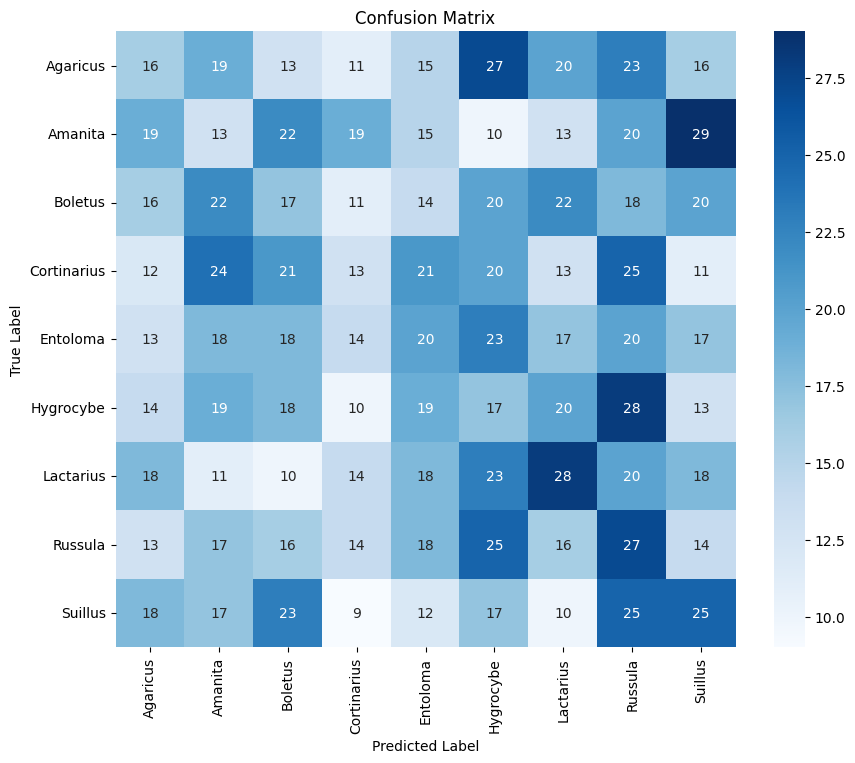

              precision    recall  f1-score   support

    Agaricus       0.12      0.10      0.11       160
     Amanita       0.08      0.08      0.08       160
     Boletus       0.11      0.11      0.11       160
 Cortinarius       0.11      0.08      0.09       160
    Entoloma       0.13      0.12      0.13       160
   Hygrocybe       0.09      0.11      0.10       158
   Lactarius       0.18      0.17      0.18       160
     Russula       0.13      0.17      0.15       160
     Suillus       0.15      0.16      0.16       156

    accuracy                           0.12      1434
   macro avg       0.12      0.12      0.12      1434
weighted avg       0.12      0.12      0.12      1434



In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Create ImageDataGenerator objects
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    '/home/liam/git/Ai_Fungi_Finder/Data_V5/Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Flow validation images in batches using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
    '/home/liam/git/Ai_Fungi_Finder/Data_V5/Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Check the class indices
print("Training class indices: ", train_generator.class_indices)
print("Validation class indices: ", validation_generator.class_indices)

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_generator.classes),
                                     y=train_generator.classes)
class_weights = dict(enumerate(class_weights))
print("Class weights: ", class_weights)

# Debugging: Check the shapes of the data
batch_x, batch_y = next(train_generator)
print("Batch X shape: ", batch_x.shape)
print("Batch Y shape: ", batch_y.shape)

# Initialise model
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

# Initialize InceptionV3 model with pre-trained weights
pre_trained_model = InceptionV3(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), include_top=False, weights="imagenet")

# Freeze the layers except the last few layers
for layer in pre_trained_model.layers[:-50]:
    layer.trainable = False

# Get the output of the last convolutional block
last_layer = pre_trained_model.output

# Add new classifier layers
x = layers.GlobalAveragePooling2D()(last_layer)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(9, activation='softmax')(x)

# Create the new model
model = models.Model(inputs=pre_trained_model.input, outputs=x)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Training the model within a try-except block to capture detailed errors
try:
    # Train the model with early stopping and checkpointing
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model_inceptionv3.h5', monitor='val_loss', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=50,
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        class_weight=class_weights  # Adding class weights
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(validation_generator)
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')
except tf.errors.InvalidArgumentError as e:
    print(str(e))

# Save the entire model
model.save('/home/liam/git/Ai_Fungi_Finder/models/InceptionV3_Spilt_150_each')

# Predict and evaluate
validation_generator.reset()
predictions = model.predict(validation_generator, steps=len(validation_generator))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(true_classes, predicted_classes, target_names=class_labels))


In [19]:
model.save('/home/liam/git/Ai_Fungi_Finder/models/InceptionSplit50')


INFO:tensorflow:Assets written to: /home/liam/git/Ai_Fungi_Finder/models/InceptionSplit50/assets


INFO:tensorflow:Assets written to: /home/liam/git/Ai_Fungi_Finder/models/InceptionSplit50/assets


# Load model for more training


In [20]:
from tensorflow.keras.models import load_model

# Load the previously saved model
from tensorflow.keras.models import load_model
model = load_model('/home/liam/git/Ai_Fungi_Finder/models/InceptionSplit50')




# Further train Model

In [22]:
# Continue training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,  # Adjust the number of epochs as needed
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
120/120 [==============================] - 50s 419ms/step - loss: 0.9757 - accuracy: 0.9621 - val_loss: 1.5171 - val_accuracy: 0.8589
Epoch 2/10
120/120 [==============================] - 52s 431ms/step - loss: 0.9734 - accuracy: 0.9574 - val_loss: 1.4858 - val_accuracy: 0.8607
Epoch 3/10
120/120 [==============================] - 51s 423ms/step - loss: 0.9531 - accuracy: 0.9611 - val_loss: 1.4980 - val_accuracy: 0.8596
Epoch 4/10
120/120 [==============================] - 51s 426ms/step - loss: 0.9533 - accuracy: 0.9632 - val_loss: 1.4837 - val_accuracy: 0.8586
Epoch 5/10
120/120 [==============================] - 51s 429ms/step - loss: 0.9490 - accuracy: 0.9592 - val_loss: 1.4715 - val_accuracy: 0.8622
Epoch 6/10
120/120 [==============================] - 51s 425ms/step - loss: 0.9406 - accuracy: 0.9673 - val_loss: 1.4807 - val_accuracy: 0.8586
Epoch 7/10
120/120 [==============================] - 48s 402ms/step - loss: 0.9159 - accuracy: 0.9697 - val_loss: 1.4819 - val_ac

2024-05-25 23:34:30.827979: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: FileNotFoundError: [Errno 2] No such file or directory: '/home/liam/git/Ai_Fungi_Finder/Data_V4/Training/Russula/590_0W5qICo2Aqk (copy).jpg'
Traceback (most recent call last):

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    ret = func(*args)

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/home/liam/an

UnknownError: Graph execution error:

2 root error(s) found.
  (0) UNKNOWN:  FileNotFoundError: [Errno 2] No such file or directory: '/home/liam/git/Ai_Fungi_Finder/Data_V4/Training/Russula/590_0W5qICo2Aqk (copy).jpg'
Traceback (most recent call last):

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    ret = func(*args)

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/keras/src/engine/data_adapter.py", line 1064, in generator_fn
    yield x[i]

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/keras/src/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/keras/src/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/keras/src/utils/image_utils.py", line 422, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: '/home/liam/git/Ai_Fungi_Finder/Data_V4/Training/Russula/590_0W5qICo2Aqk (copy).jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) UNKNOWN:  FileNotFoundError: [Errno 2] No such file or directory: '/home/liam/git/Ai_Fungi_Finder/Data_V4/Training/Russula/590_0W5qICo2Aqk (copy).jpg'
Traceback (most recent call last):

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    ret = func(*args)

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/keras/src/engine/data_adapter.py", line 1064, in generator_fn
    yield x[i]

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/keras/src/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/keras/src/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/home/liam/anaconda3/envs/ai4robotics/lib/python3.8/site-packages/keras/src/utils/image_utils.py", line 422, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: '/home/liam/git/Ai_Fungi_Finder/Data_V4/Training/Russula/590_0W5qICo2Aqk (copy).jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_765804]

# Save Model



In [ ]:
# Save the entire model
model.save('/content/drive/My Drive/efficient_net_mushroom_classifier.h5')


# Confusion matrix

45/45 [==============================] - 5s 120ms/step


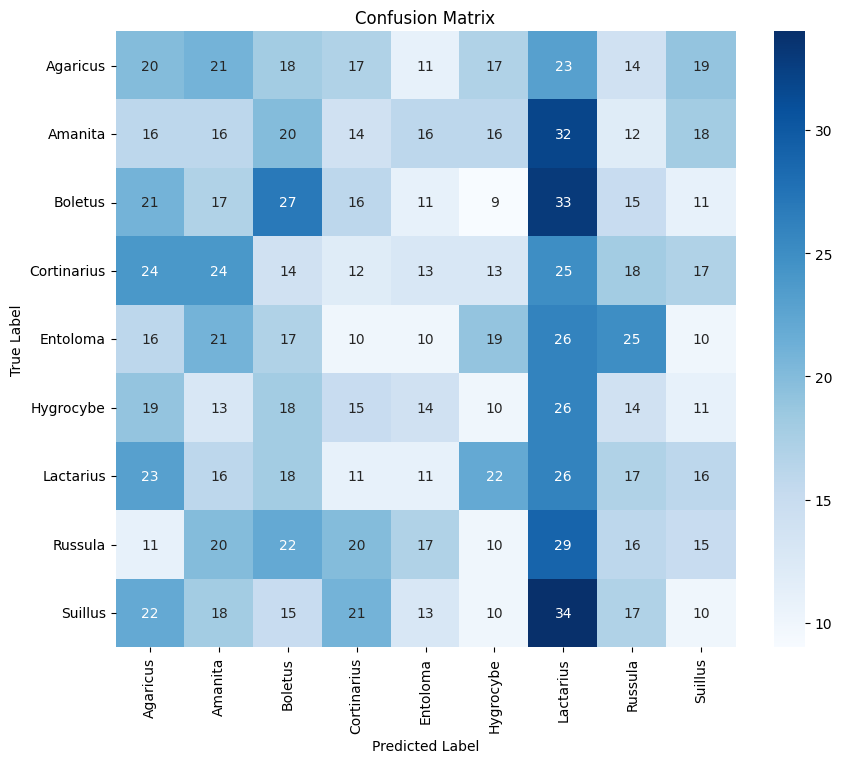

              precision    recall  f1-score   support

    Agaricus       0.12      0.12      0.12       160
     Amanita       0.10      0.10      0.10       160
     Boletus       0.16      0.17      0.16       160
 Cortinarius       0.09      0.07      0.08       160
    Entoloma       0.09      0.06      0.07       154
   Hygrocybe       0.08      0.07      0.08       140
   Lactarius       0.10      0.16      0.13       160
     Russula       0.11      0.10      0.10       160
     Suillus       0.08      0.06      0.07       160

    accuracy                           0.10      1414
   macro avg       0.10      0.10      0.10      1414
weighted avg       0.10      0.10      0.10      1414



In [10]:
# Reset the validation generator
from sklearn.metrics import confusion_matrix, classification_report

validation_generator.reset()

# Make predictions
predictions = model.predict(validation_generator, steps=len(validation_generator))

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Retrieve true class indices
true_classes = validation_generator.classes

# Retrieve class labels
class_labels = list(validation_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Classification Section

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image as k_image
from tensorflow.keras.applications.inception_v3 import preprocess_input

def predict_mushroom_species(img_path, model, class_labels):
    # Load the image file, resizing it to 224x224 pixels (as required by the model)
    img = k_image.load_img(img_path, target_size=(224, 224))
    # Convert the image to a numpy array
    img_array = k_image.img_to_array(img)
    # Add a fourth dimension to the image (since Keras expects a list of images, not a single image)
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess the image by scaling pixel values to match the original model's training input
    img_array = preprocess_input(img_array)
    # Make predictions
    predictions = model.predict(img_array)
    # Retrieve the most likely result, e.g., highest probability
    predicted_class_idx = np.argmax(predictions[0])
    # Map the index to the class label
    predicted_class_label = class_labels[predicted_class_idx]
    return predicted_class_label

# Example usage
img_path = '/content/Ai_Fungi_Finder/Data_V3/Training/Agaricus/299_lLa-uv876WM.jpg'  # Path to new mushroom image
predicted_class = predict_mushroom_species(img_path, model, list(train_generator.class_indices.keys()))
print(f'Predicted Mushroom Species: {predicted_class}')


1/1 [==============================] - 0s 32ms/step
Predicted Mushroom Species: Russula


In [ ]:
from tensorflow.keras.models import Model

# Assume 'pre_trained_model' is your VGG16 model loaded without the top and with ImageNet weights
feature_extractor = Model(inputs=pre_trained_model.input, outputs=pre_trained_model.get_layer('block5_pool').output)
from sklearn.decomposition import PCA
import numpy as np

def apply_pca_to_model(model, generator, num_components=50):
    """
    Applies PCA to the output of a given model based on the data provided by a generator.

    Args:
    - model: TensorFlow/Keras model to extract features.
    - generator: Data generator that feeds data into the model.
    - num_components: Number of principal components to retain.

    Returns:
    - pca_features: PCA-reduced feature set.
    """
    # Extract features from the model using the generator
    features = model.predict(generator, steps=len(generator))

    # Reshape the features to be two-dimensional
    num_samples = features.shape[0]
    features_flattened = features.reshape(num_samples, -1)

    # Initialize and fit PCA
    pca = PCA(n_components=num_components)
    pca_features = pca.fit_transform(features_flattened)

    return pca_features
